# Train a classifier free guaidance diffusion model for generating image according to condtion. 
## Conditions - Normal, Level_1, Level_2,Level_3, Worse. The conditons are based the disease condition level of Knee Osteoarthritis.

Import the libraries

In [1]:
import os
import shutil
import tempfile

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import LatentDiffusionInferer
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

import cv2
import glob
from torch.utils.data import Dataset, DataLoader
torch.cuda.empty_cache()
print_config()

MONAI version: 1.2.0
Numpy version: 1.26.0
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/default/miniconda3/envs/monai_generative_ai/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.22.0
Pillow version: 10.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.0+cu121
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.1.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about instal

In [2]:
set_determinism(42)

## Custom Dataset same as that is used in autoencoder
## 0 -> null class , 1 -> Normal , 2 -> Level_1 , 3 -> Level_2, 4 -> Level_3, 5-> Worse.

In [3]:
class CustomDataset(Dataset):
  def __init__(self,path):
    self.imgs_path = path
    file_list = glob.glob(self.imgs_path+ "*")

    self.data=[]
    for class_path in file_list:
      class_name = class_path.split("/")[-1]
      for img_path in glob.glob(class_path+"/*"):
          self.data.append([img_path,1+int(class_name)])
        # self.data.append([img_path,1 if class_name=="0" or class_name =="1" else 2])

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    img_path,class_id = self.data[idx]
    img = cv2.imread(img_path)
    img = cv2.resize(img,(112,112)) # resizing here
    gray_image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray_image.resize(112,112,1)
    img_tensor = torch.from_numpy(gray_image*1.0)
    img_tensor = img_tensor.permute(2,0,1)
    class_id = torch.tensor([class_id])
    img_tensor /= 255.
    return img_tensor.float() , class_id.squeeze()

In [4]:
## Define the custom dataset
training_dataset = CustomDataset('/home/default/monai_generative_ai/Knee_Osteoarthritis/train/')
validation_dataset = CustomDataset('/home/default/monai_generative_ai/Knee_Osteoarthritis/val/')

In [5]:
len(training_dataset)

5778

In [6]:
len(validation_dataset)

826

# Load autoencoder

In [7]:
device = torch.device("cuda")

autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 128, 256),
    latent_channels=3,
    num_res_blocks=2,
    attention_levels=(False, False, False),
    with_encoder_nonlocal_attn=False,
    with_decoder_nonlocal_attn=False,
)
PATH_auto = '/home/default/monai_generative_ai/auto_encoder_model.pt'

In [8]:
autoencoderkl.load_state_dict(torch.load(PATH_auto))
autoencoderkl.to(device)

AutoencoderKL(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): Convolution(
        (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x ResBlock(
        (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
        (conv2): Convolution(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (nin_shortcut): Identity()
      )
      (3): Downsample(
        (conv): Convolution(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (4-5): 2 x ResBlock(
        (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norm2): GroupNorm(3

## Define embedding and Diffusion models

In [9]:
embedding_dimension = 64
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_res_blocks=2,
    num_channels=(128, 256, 512),
    attention_levels=(False, True, True),
    num_head_channels=(0, 256, 512),
    with_conditioning=True,
    cross_attention_dim=embedding_dimension
)
unet = unet.to(device)
embed = torch.nn.Embedding(num_embeddings=6, embedding_dim=embedding_dimension, padding_idx=0).to(device)
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

In [10]:
train_loader = DataLoader(training_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

In [11]:
check_data = first(train_loader)

## Get scaling factor for LatentDiffusionInferer from autoencoder

In [13]:
with torch.no_grad():
    with autocast(enabled=True):
        # inp = check_data[0].to(device)
        z = autoencoderkl.encode_stage_2_inputs(check_data[0].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to 0.943597137928009


In [14]:
inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

In [15]:
optimizer = torch.optim.Adam(params=list(unet.parameters()) + list(embed.parameters()), lr=1e-5)

## Check the shape of images and classes

In [17]:
condition_dropout = 0.15
for batch in train_loader:
    images = batch[0].to(device)
    classes = batch[1].to(device)
    classes = classes * (torch.rand_like(classes.float())>condition_dropout)
    class_embedding = embed(classes.long().to(device)).unsqueeze(1)
    break

In [18]:
images.shape

torch.Size([64, 1, 112, 112])

In [19]:
classes

tensor([3, 1, 4, 1, 3, 3, 1, 0, 1, 3, 4, 5, 1, 1, 4, 2, 0, 2, 3, 3, 1, 4, 3, 2,
        3, 2, 0, 1, 4, 4, 3, 3, 0, 0, 0, 1, 3, 1, 3, 3, 1, 2, 1, 3, 1, 4, 0, 3,
        1, 3, 1, 1, 1, 0, 3, 4, 0, 2, 4, 1, 1, 1, 1, 4], device='cuda:0')

In [21]:
class_embedding.shape

torch.Size([64, 1, 64])

## Training , Save the checkpoints in checkpoints directory 

In [23]:
condition_dropout = 0.15
n_epochs = 300
val_interval = 40
epoch_losses = []
val_losses = []
scaler = GradScaler()

train_loader = DataLoader(training_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

for epoch in range(n_epochs):

    if(epoch%25 ==0 and epoch !=0):
        print("saving model")
        torch.save({
            'epoch': epoch,
            'model_state_dict': unet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'embed_state_dict':embed.state_dict(),
            'loss': loss,
            }, f"checkpoints/{epoch}.pth")
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch[0].to(device)
        classes = batch[1].to(device)
        classes = classes * (torch.rand_like(classes.float())>condition_dropout)
        class_embedding = embed(classes.long().to(device)).unsqueeze(1)
        
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            z_mu, z_sigma = autoencoderkl.encode(images)
            z = autoencoderkl.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(device)
            timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device).long()
            noise_pred = inferer(
                inputs=images, diffusion_model=unet, noise=noise, timesteps=timesteps, autoencoder_model=autoencoderkl,
                condition=class_embedding
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_losses.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch[0].to(device)
                classes  = batch[1].to(device)
                classes = classes * (torch.rand_like(classes.float())>condition_dropout)
                class_embedding = embed(classes.long().to(device)).unsqueeze(1)
                with autocast(enabled=True):
                    z_mu, z_sigma = autoencoderkl.encode(images)
                    z = autoencoderkl.sampling(z_mu, z_sigma)

                    noise = torch.randn_like(z).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
                    ).long()
                    noise_pred = inferer(
                        inputs=images,
                        diffusion_model=unet,
                        noise=noise,
                        timesteps=timesteps,
                        autoencoder_model=autoencoderkl,
                        condition=class_embedding
                    )

                    loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= val_step
        val_losses.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training
        # z = torch.randn((1, 3, 28, 28))
        # z = z.to(device)
        # scheduler.set_timesteps(num_inference_steps=1000)
        # with autocast(enabled=True):
        #     decoded = inferer.sample(
        #         input_noise=z, diffusion_model=unet, scheduler=scheduler, autoencoder_model=autoencoderkl
        #     )

        # plt.figure(figsize=(2, 2))
        # plt.style.use("default")
        # plt.imshow(decoded[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
        # plt.tight_layout()
        # plt.axis("off")
        # plt.show()
progress_bar.close()

Epoch 24: 100%|███████████| 91/91 [00:23<00:00,  3.88it/s, loss=0.147]


saving model


Epoch 39: 100%|████████████| 91/91 [00:23<00:00,  3.89it/s, loss=0.14]


Epoch 39 val loss: 0.1490


Epoch 49: 100%|███████████| 91/91 [00:23<00:00,  3.89it/s, loss=0.142]


saving model


Epoch 74: 100%|███████████| 91/91 [00:23<00:00,  3.89it/s, loss=0.144]


saving model


Epoch 79: 100%|███████████| 91/91 [00:23<00:00,  3.89it/s, loss=0.142]


Epoch 79 val loss: 0.1338


Epoch 99: 100%|███████████| 91/91 [00:23<00:00,  3.88it/s, loss=0.135]


saving model


Epoch 119: 100%|██████████| 91/91 [00:23<00:00,  3.89it/s, loss=0.133]


Epoch 119 val loss: 0.1514


Epoch 124: 100%|██████████| 91/91 [00:23<00:00,  3.89it/s, loss=0.138]


saving model


Epoch 149: 100%|██████████| 91/91 [00:23<00:00,  3.89it/s, loss=0.135]


saving model


Epoch 159: 100%|██████████| 91/91 [00:23<00:00,  3.89it/s, loss=0.137]


Epoch 159 val loss: 0.1372


Epoch 174: 100%|██████████| 91/91 [00:23<00:00,  3.89it/s, loss=0.135]


saving model


Epoch 199: 100%|██████████| 91/91 [00:23<00:00,  3.90it/s, loss=0.137]


Epoch 199 val loss: 0.1456
saving model


Epoch 224: 100%|██████████| 91/91 [00:23<00:00,  3.89it/s, loss=0.136]


saving model


Epoch 239: 100%|██████████| 91/91 [00:23<00:00,  3.89it/s, loss=0.135]


Epoch 239 val loss: 0.1482


Epoch 249: 100%|██████████| 91/91 [00:23<00:00,  3.89it/s, loss=0.136]


saving model


Epoch 274: 100%|██████████| 91/91 [00:23<00:00,  3.89it/s, loss=0.132]


saving model


Epoch 279: 100%|██████████| 91/91 [00:23<00:00,  3.89it/s, loss=0.137]


Epoch 279 val loss: 0.1653


Epoch 299: 100%|██████████| 91/91 [00:23<00:00,  3.89it/s, loss=0.135]


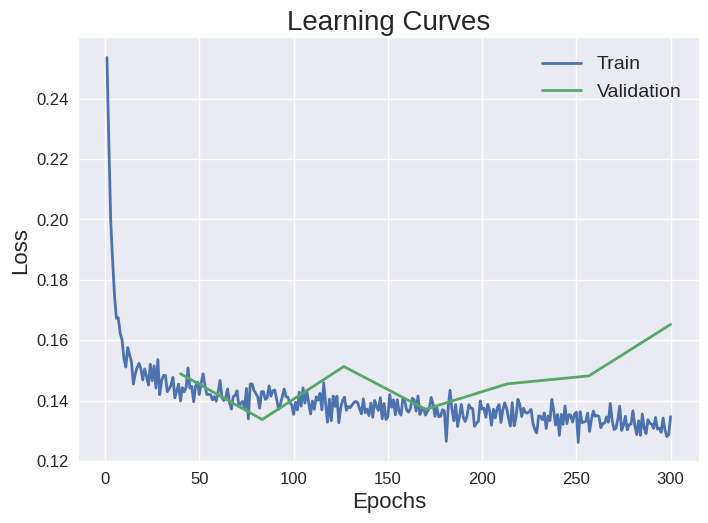

In [26]:
plt.figure()
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_losses, linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)), val_losses, linewidth=2.0, label="Validation"
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})

## Model Evalution

In [29]:
#Model evaluation

unet.eval()
scheduler.clip_sample = True
guidance_scale = 3
conditioning = torch.cat([torch.zeros(1).long(), 3 * torch.ones(1).long()], dim=0).to(
    device
)  
class_embedding = embed(conditioning).unsqueeze(
    1
)  # cross attention expects shape [batch size, sequence length, channels]


100%|██████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 41.99it/s]


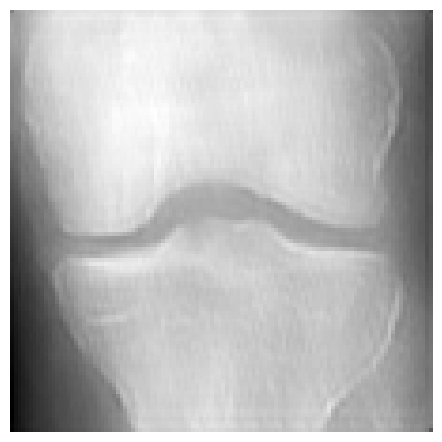

In [52]:
unet.eval()
scheduler.clip_sample = True
guidance_scale = 3
conditioning = torch.cat([torch.zeros(1).long(), 1 * torch.ones(1).long()], dim=0).to(
    device
) 
class_embedding = embed(conditioning).unsqueeze(
    1
)  # cross attention expects shape [batch size, sequence length, channels]
scheduler.set_timesteps(num_inference_steps=1000)
noise = torch.randn((1, 3, 28, 28))
noise = noise.to(device)

progress_bar = tqdm(scheduler.timesteps)
for t in progress_bar:
    with autocast(enabled=True):
        with torch.no_grad():
            noise_input = torch.cat([noise] * 2)
            model_output = unet(noise_input, timesteps=torch.Tensor((t,)).to(noise.device), context=class_embedding,)
            noise_pred_uncond, noise_pred_text = model_output.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    noise, _ = scheduler.step(noise_pred, t, noise)
with torch.no_grad():
    noise = autoencoderkl.decode(noise)
plt.style.use("default")
plt.imshow(noise[0, 0].cpu(), cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()


## Save the final model

In [53]:
epoch = 300
torch.save({
            'epoch': epoch,
            'model_state_dict': unet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'embed_state_dict':embed.state_dict(),
            'loss': loss,
            }, f"checkpoints/{epoch}.pth")

In [54]:
PATH_unet_condition = '/home/default/monai_generative_ai/unet_latent_space_model_condition.pt'
PATH_embed_condition = '/home/default/monai_generative_ai/embed_latent_space_model_condition.pt'

In [2]:
#Uncoment the following lines to save the models separately
# torch.save(unet.state_dict(), PATH_unet_condition)
# torch.save(embed.state_dict(), PATH_embed_condition)